# Overview

first implement vanilla RNN and simple SGD without the helper functions. Then use the `optim` module and run the same network with `cuda`.

### Todo:
- [ ] the training is not working. Need to figure out what to do, potentially change to aother problem
- [ ] see if I can setup to use the same network for shakespeare's text

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import forward_tracer, backward_tracer, Char2Vec, num_flat_features

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from tqdm import tqdm

from IPython.display import clear_output

In [2]:
class SimpleRNN(nn.Module):
    def __init__(self, data_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(data_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        #self.h2o.register_forward_hook(forward_tracer)
        #self.h2o.register_backward_hook(backward_tracer)
        self.softmax = F.softmax
        
    def forward(self, x, hidden):
        inp = torch.cat((x, hidden), 1)
        self.hidden = self.i2h(inp)
        output = self.h2o(self.hidden.float())
        return output, self.hidden

In [3]:
source = "";
with open('./data/shakespeare.txt', 'r') as f:
    for line in f:
        source += line + "\n"
        
source += "      "
print([source[:60]])

['First Citizen:\n\nBefore we proceed any further, hear me speak']


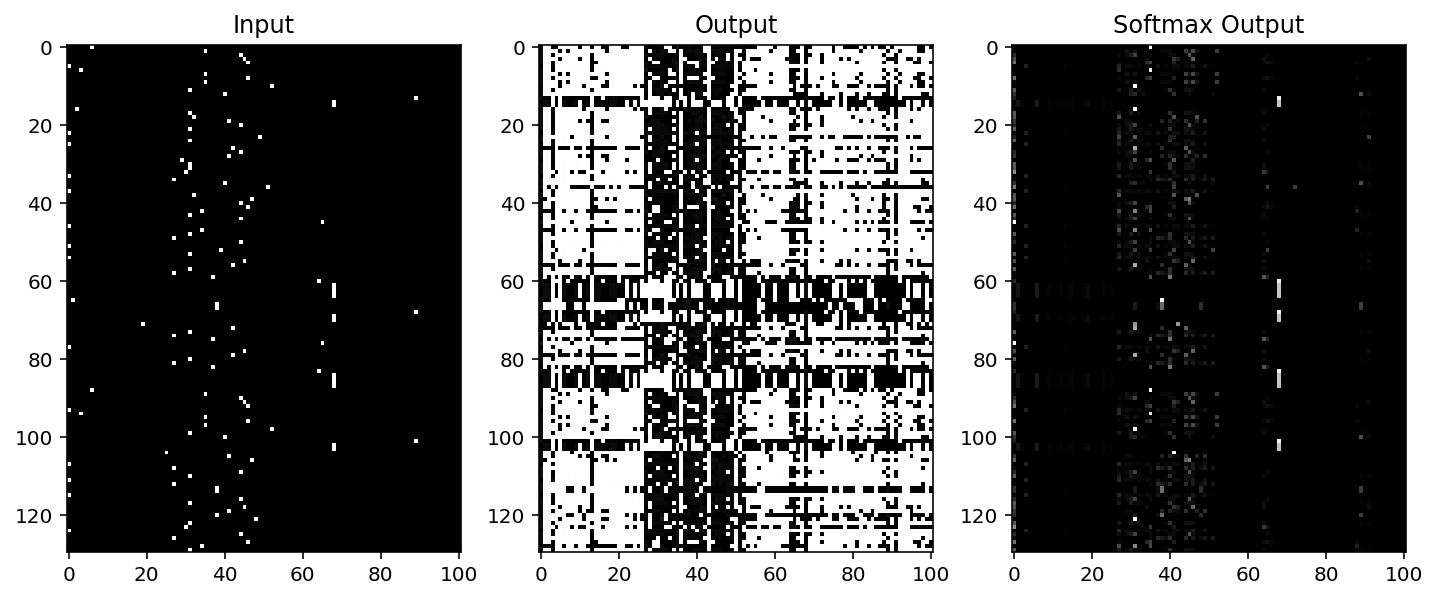

 72%|███████▏  | 181206/250000 [1:03:42<1:05:21, 17.54it/s]

itst ait te :


e   s ae aes o   an: a ss e s ae n


 72%|███████▏  | 181219/250000 [1:03:42<42:04, 27.24it/s]  

In [ ]:
learning_rate = 2e-2
char2vec = Char2Vec()
input_size = len(char2vec.chars)
hidden_size = input_size
TIME_STEPS = 10 # source_length

model = SimpleRNN(input_size, hidden_size, input_size)
loss_fn = nn.CrossEntropyLoss()


for step in tqdm(range(250000)):
        
    hidden = hidden.detach()
    
    source_ = source[:500]
    source_length = len(source_)
    input_vec = Variable(char2vec.one_hot(source_))
    target_vec = Variable(char2vec.char_code(source_[1:] + " "))
    hidden = Variable(torch.zeros(source_length, hidden_size))    

    model.zero_grad()
    loss = 0
    
    for t in range(TIME_STEPS):                  
        # yes! you can reuse the same network several times,
        # sum up the losses, and call backward!
        output, hidden = model(input_vec, hidden)
        loss += loss_fn(output.view(-1, input_size), target_vec)
    

    loss.backward()
    #optimizer = optim.Adam(model.parameters(), lr=1e-2)
    
    for p in model.parameters():
        # print(p.grad)
        p.data -= learning_rate * p.grad.data
    
    if step%200 == 199:
        clear_output(wait=True)
        
        softmax_output = model.softmax(output).cpu().data.numpy()
        string_output = ''.join([char2vec.chars[row.argmax()] for row in softmax_output])

        plt.figure(figsize=(12, 9))
        plt.subplot(131)
        plt.title("Input")
        plt.imshow(input_vec.data.byte().numpy()[:130], cmap="Greys_r", interpolation="none")
        plt.subplot(132)
        plt.title("Output")
        plt.imshow(output.data.byte().numpy()[:130], cmap="Greys_r", interpolation="none")
        plt.subplot(133)
        plt.title("Softmax Output")
        plt.imshow(model.softmax(output).cpu().data.numpy()[:130], cmap="Greys_r", interpolation="none")
        plt.show()
        
        print(string_output[:50])

## Writing the gradient descent with an optimizer (and run on GPU)

In [5]:
# Setting variables to save to the GPU
x = Variable(torch.ones(1,1))
y = Variable(torch.ones(1,10))
z = torch.cat((x, y), 1).cuda()
print(x, y, z)

Variable containing:
 1
[torch.FloatTensor of size 1x1]
 Variable containing:
    1     1     1     1     1     1     1     1     1     1
[torch.FloatTensor of size 1x10]
 Variable containing:
    1     1     1     1     1     1     1     1     1     1     1
[torch.cuda.FloatTensor of size 1x11 (GPU 0)]



#### TLDR;
- cpu is 2x faster than GPU for source length of 1250
- Variables created via numpy-bridge need to be copied to CPU first before they can be set via `.cuda()`.

Here we try to run all of the coputation on the GPU. It turned out that in this case the `.cuda` version runs a bit slower than on the cpu. 

One tricky lession I learned from this is that in order for a Variable defined with the numpy bridge to be used with `.cuda`, I need to first copy it to the CPU and only after then can I set it to `.cuda()`. 

This took quite a bit of debugging and research to figure out!

In [9]:
source = "".join(["0+0=?;0+1=?;1+1=?;1+2=?;"]*40)
target = "".join(["    0;    1;    2;    3;"]*40)

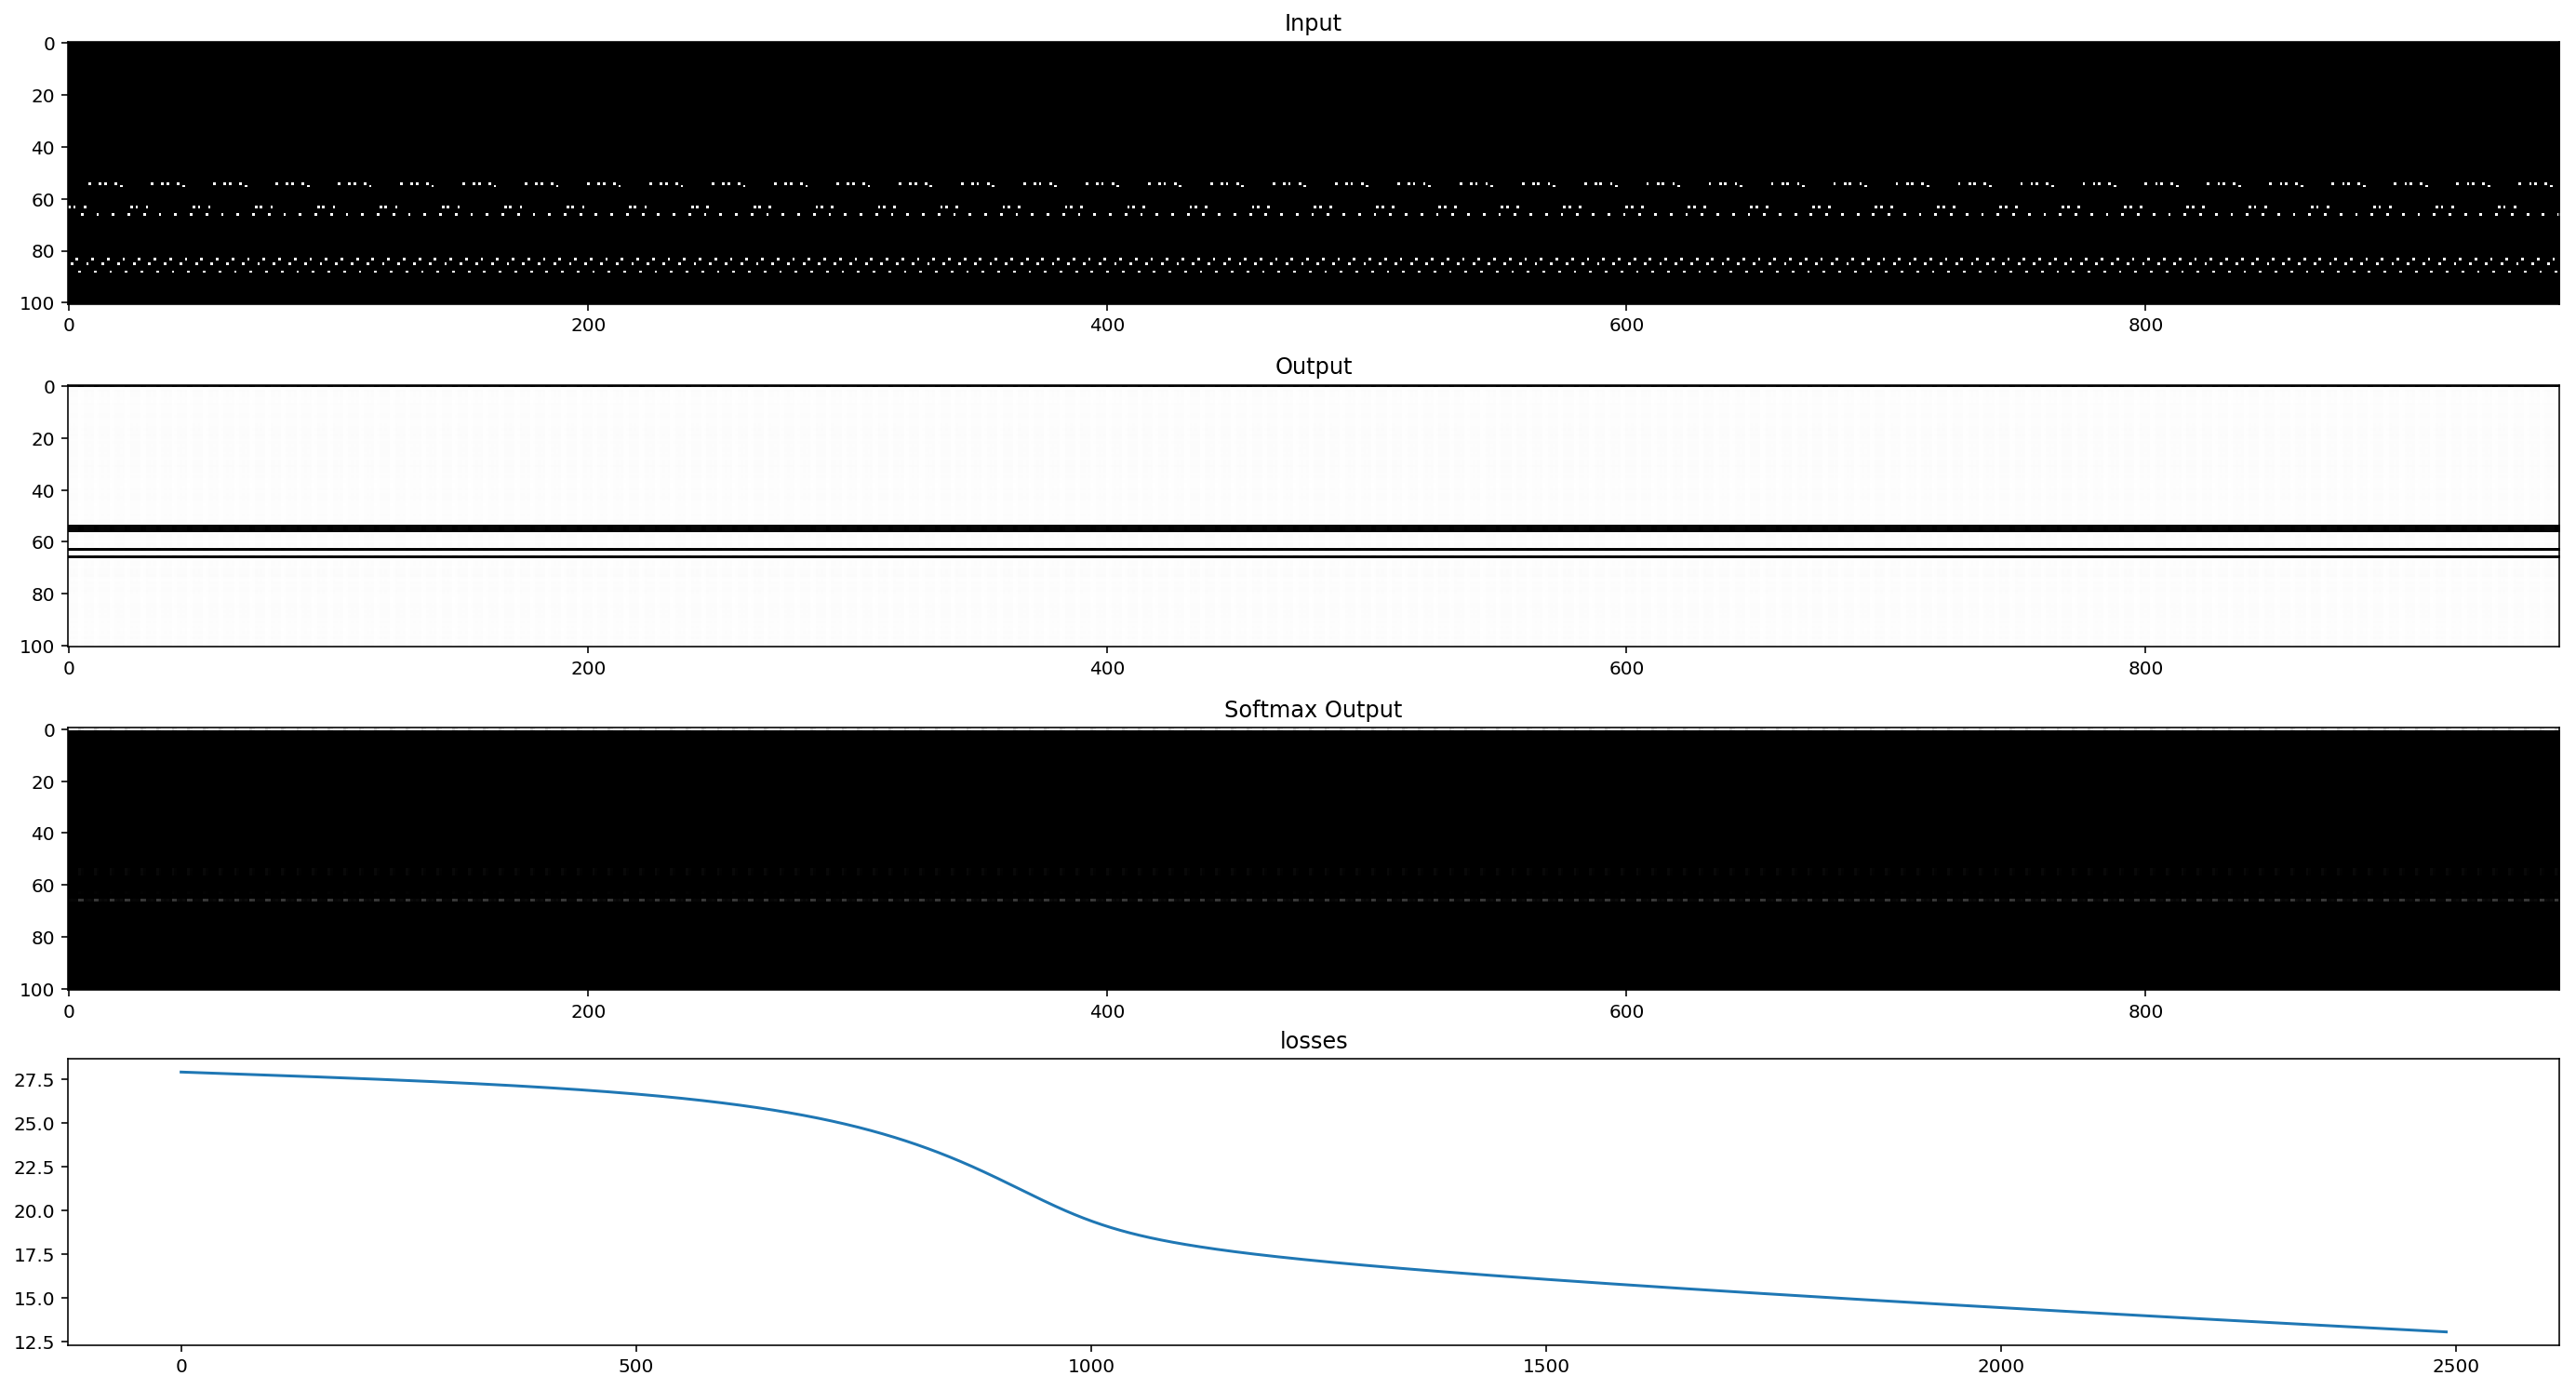

100%|██████████| 2500/2500 [02:11<00:00, 19.59it/s]

13.0573
['0+0=?;0+1=?;1+1=?;1+2=?;0+0=?;0+1=?;1+1=?;1+2=?;0+']
['                                                  ']


In [10]:
learning_rate = 5e-6
char2vec = Char2Vec()
input_size = len(char2vec.chars)
hidden_size = 200
source_length = len(source)
TIME_STEPS = 6 # source_length

model = SimpleRNN(input_size, hidden_size, input_size)
model.cuda()
loss_fn = nn.CrossEntropyLoss()

input_vec = Variable(char2vec.one_hot(source)).cuda()
target_vec = Variable(char2vec.char_code(target)).cuda()

hidden = Variable(torch.FloatTensor(source_length, hidden_size)).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for step in tqdm(range(2500)):
        
    hidden.data.zero_()
    hidden = hidden.detach()
    optimizer.zero_grad()
    loss = 0
    
    for t in range(TIME_STEPS):                  
        # yes! you can reuse the same network several times,
        # sum up the losses, and call backward!
        output, hidden = model(input_vec, hidden)
        loss += loss_fn(output, target_vec).cuda()
    
    #print(loss)
    loss.backward()
    optimizer.step()

    losses.append(loss.data.cpu().numpy()[0])
    if step%30 == 29:
        clear_output(wait=True)
        
        softmax_output = model.softmax(output).cpu().data.numpy()
    
        string_output = ''.join([char2vec.chars[row.argmax()] for row in softmax_output])

        plt.figure(figsize=(24, 13))
        plt.subplot(411)
        plt.title("Input")
        plt.imshow(input_vec.clone().cpu().data.byte().numpy().transpose(), cmap="Greys_r", interpolation="none")
        plt.subplot(412)
        plt.title("Output")
        plt.imshow(output.clone().cpu().data.byte().numpy().transpose(), cmap="Greys_r", interpolation="none")
        plt.subplot(413)
        plt.title("Softmax Output")
        plt.imshow(softmax_output.transpose(), cmap="Greys_r", interpolation="none")
        plt.subplot(414)
        plt.title("losses")
        plt.plot(losses)
        plt.show()
        
        print(losses[-1])
        print([source[:50]])
        print([string_output[:50]])

## Now use the network to infer equations

In [11]:
from ipywidgets import widgets
from IPython.display import display

['      ']


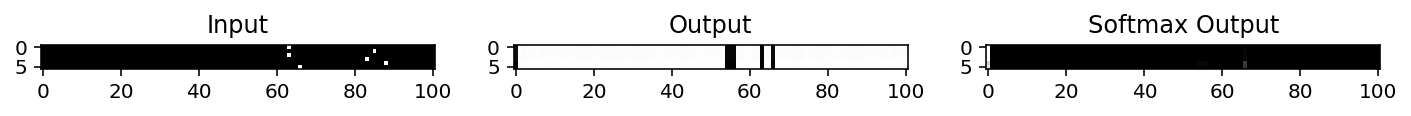

None


In [12]:
def predict_next(source):
    
    clear_output()
    
    source_length = len(source)
    
    # model.cuda()
    input_vec = Variable(char2vec.one_hot(source)).cuda()
    hidden = Variable(torch.zeros(source_length, hidden_size)).cuda()
    
    for t in range(TIME_STEPS):                  
        # yes! you can reuse the same network several times,
        # sum up the losses, and call backward!
        output, hidden = model(input_vec, hidden)
        
    softmax_output = model.softmax(output).cpu().data.numpy()
    
    string_output = ''.join([char2vec.chars[row.argmax()] for row in softmax_output])
    
    print([string_output])
    
    plt.figure(figsize=(12, 9))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(input_vec.cpu().data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(132)
    plt.title("Output")
    plt.imshow(output.cpu().data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(133)
    plt.title("Softmax Output")
    plt.imshow(softmax_output, cmap="Greys_r", interpolation="none")
    plt.show();

print(predict_next("0+0=?;"));

['     ']


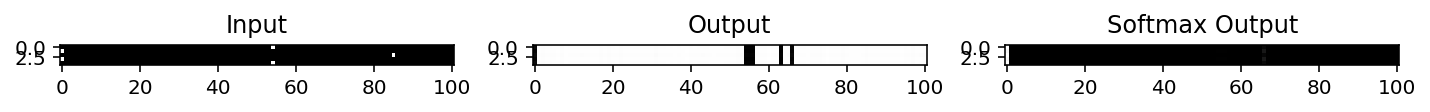

In [13]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    #print(text_input.value)
    predict_next(text_input.value)
    
text_input.on_submit(handle_submit)

The prediction is still not working yet.  😅